## 7장. 합성곱 신경망(CNN)

In [2]:
from PIL import Image

### 7.1 전체 구조 

- Affine 계층은 완전연결 계층이다.
- Affine 계층 뒤에는 활성화 함수 Relu 가 이어진다. 마지막 결과물에 소프트맥스 계층으로 최종확률 출력

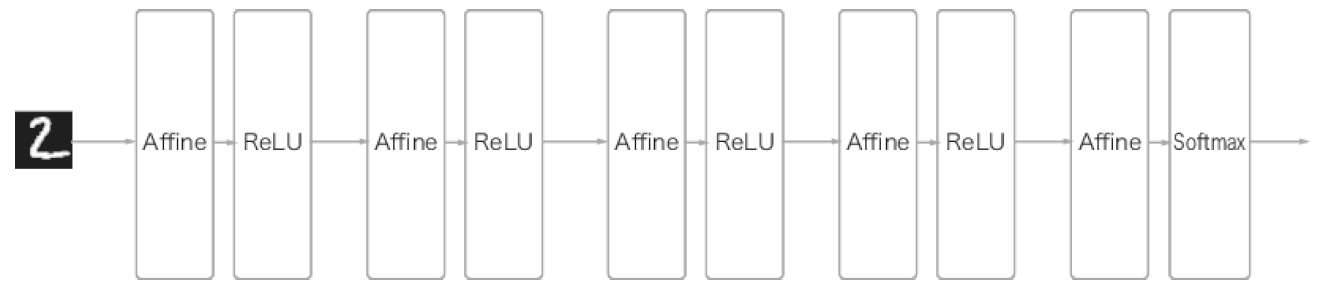

In [5]:
im = Image.open('deep_learning_images/fig 7-1.png')
im

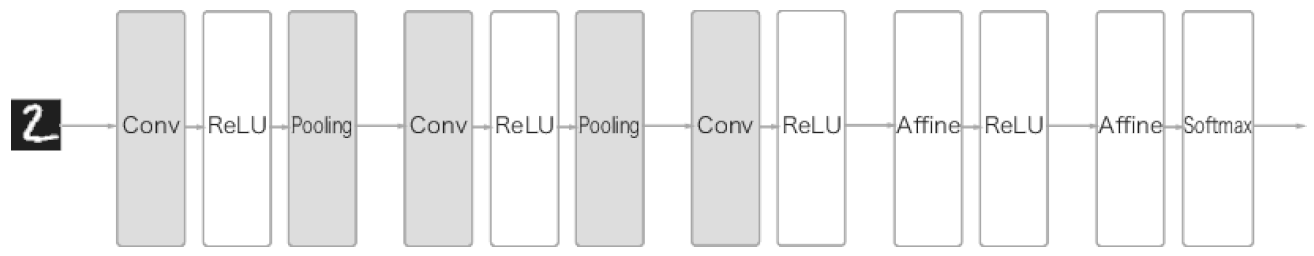

In [6]:
im = Image.open('deep_learning_images/fig 7-2.png')
im

- CNN에서는 합성곱계층과 풀링계층이 추가됨

### 7. 2 합성곱 계층

- 완전연결 계층의 문제점 -> 데이터의 형상이 무시된다
- 예를들어 이미지는 3차원 이지만 평평한 1차원으로 평탄화해줘야한다.
- 공간(형상)에 담긴 정보가 소실된다.
- 합성곱 계층은 그대로 전달가능
- 입출력 데이터를 특징 맵이라고 한다.

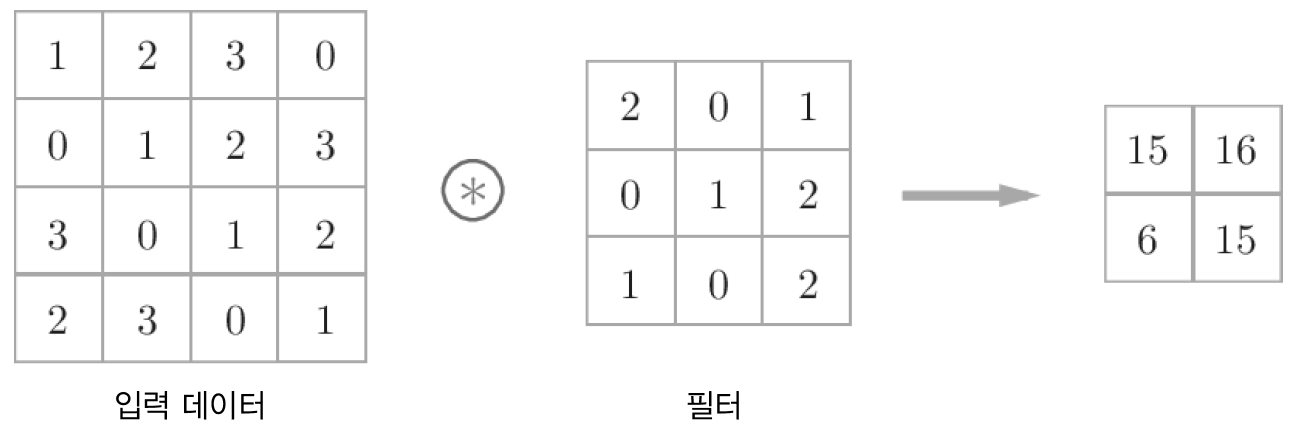

In [10]:
im = Image.open('deep_learning_images/fig 7-3.png')
im

- 합성곱 연산은 입력 데이터에 필터(커널)를 적용 
- 필터의 매개변수가 완전연결 신경망의 가중치에 해당하는것
- 필터의 윈도우를 이동해가며 입력 데이터에 적용한다.

### 패딩

- 합성곱 연산을 수행하기 전에 입력데이터 주변을 특정값(예를들어 0)으로 채우는것
- 출력크기를 조정할 목적으로 수행 
- 패딩을 수행하니 입력 데이터의 공간적 크기를 고정 한채로 다음 계층에 전달이 가능

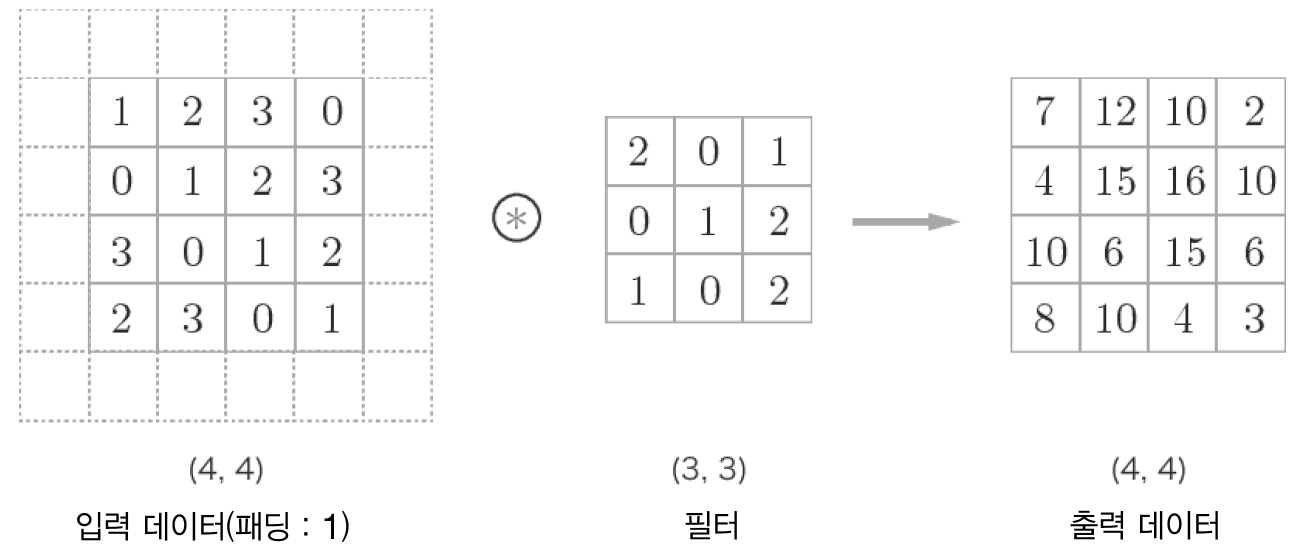

In [14]:
im = Image.open('deep_learning_images/fig 7-6.png')
im

### 스트라이드

- 필터를 적용하는 위치의 간격
- 출력 크기(OH, OW)가 정수가 되도록 패딩(P) 스트라이드(S) 필터크기(FH,FW), 입력크기(H,W)를 조정해야한다. or 반올림등 처리필요

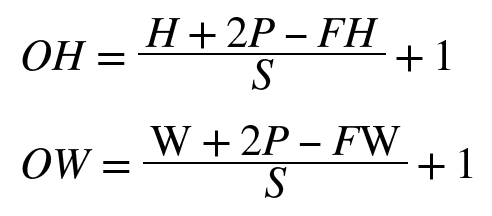

In [17]:
im = Image.open('deep_learning_images/e 7.1.png')
im

### 3차원 데이터 합성곱 연산

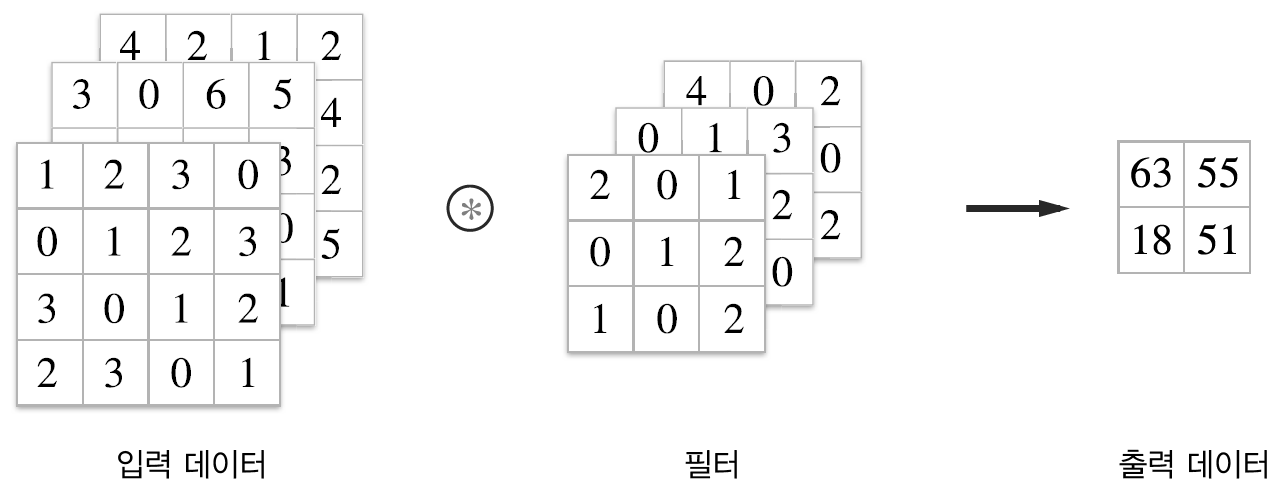

In [19]:
im = Image.open('deep_learning_images/fig 7-8.png')
im

- 합성곱 연산에서는 입력 데이터의 채널 수가와 필터의 채널수가 같아야 한다.

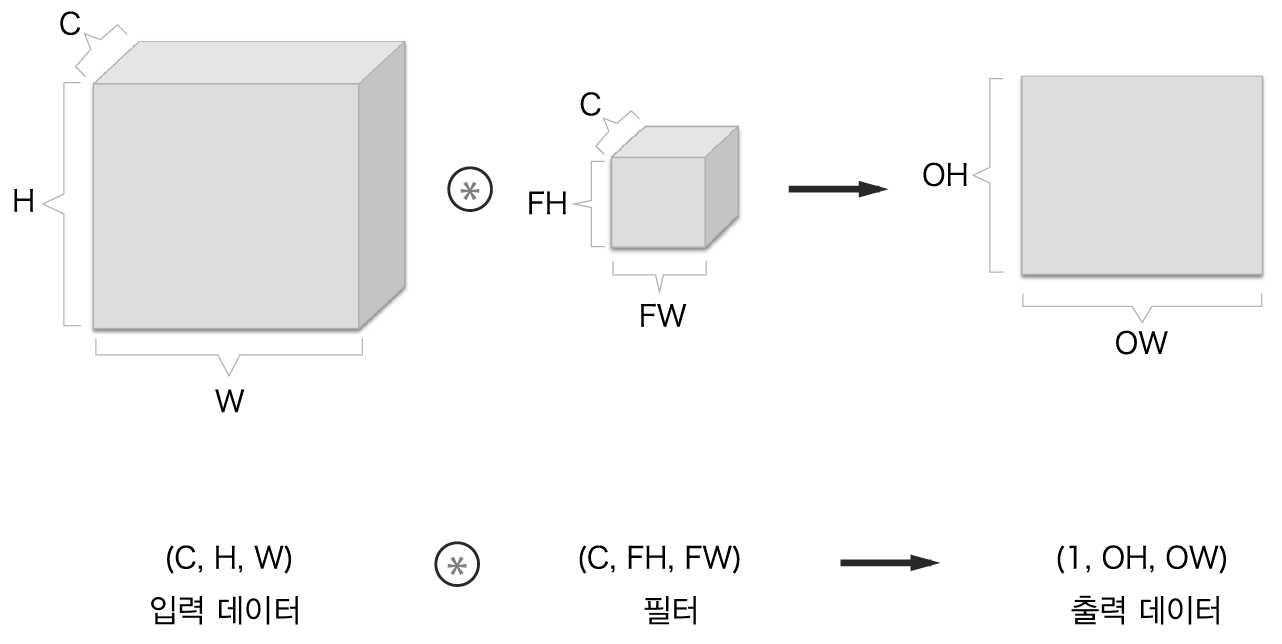

In [21]:
im = Image.open('deep_learning_images/fig 7-10.png')
im

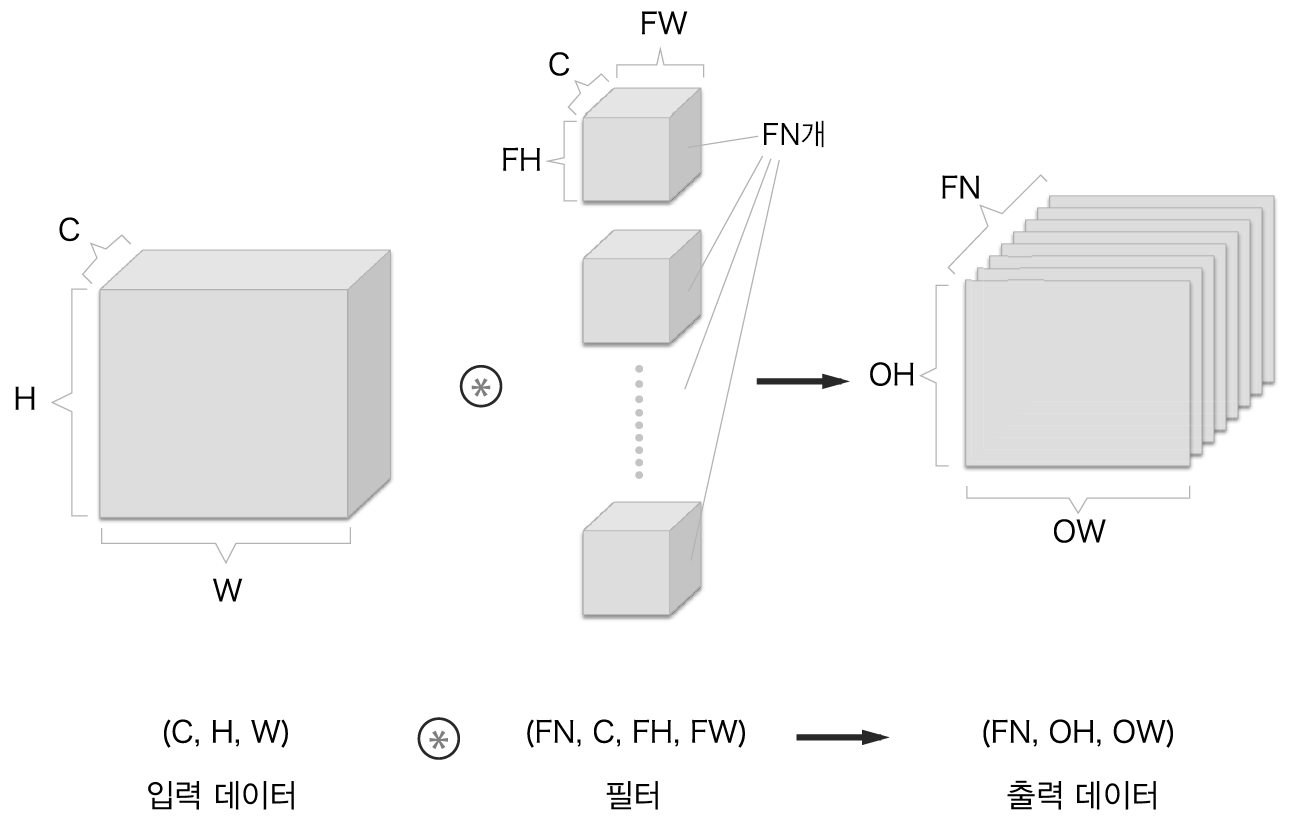

In [22]:
im = Image.open('deep_learning_images/fig 7-11.png')
im

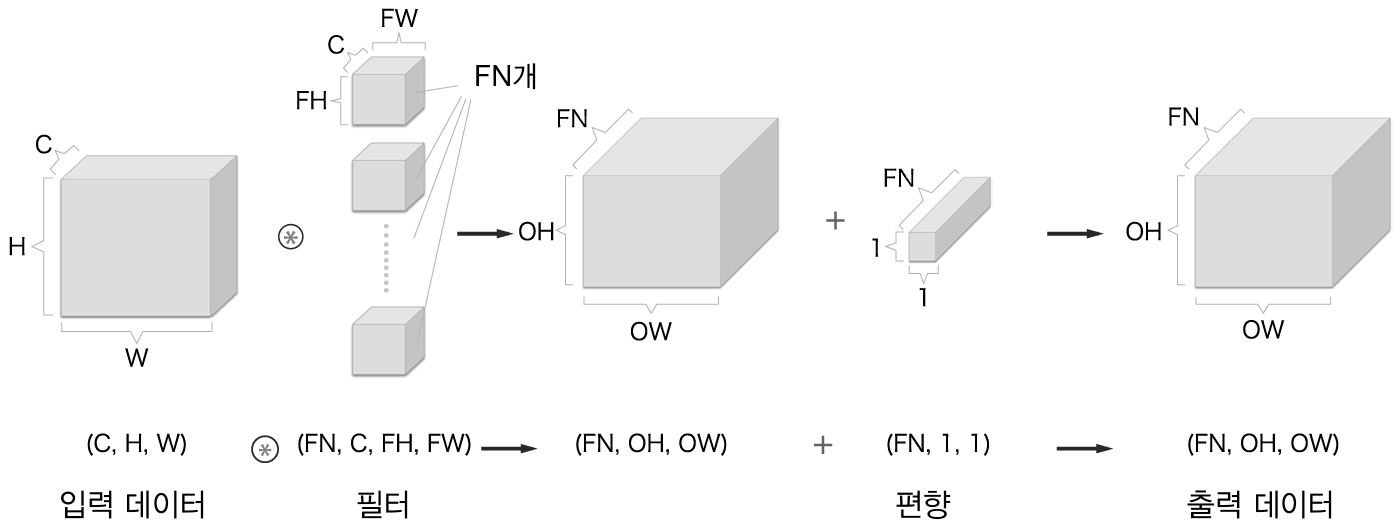

In [23]:
im = Image.open('deep_learning_images/fig 7-12.png')
im

### 배치 처리

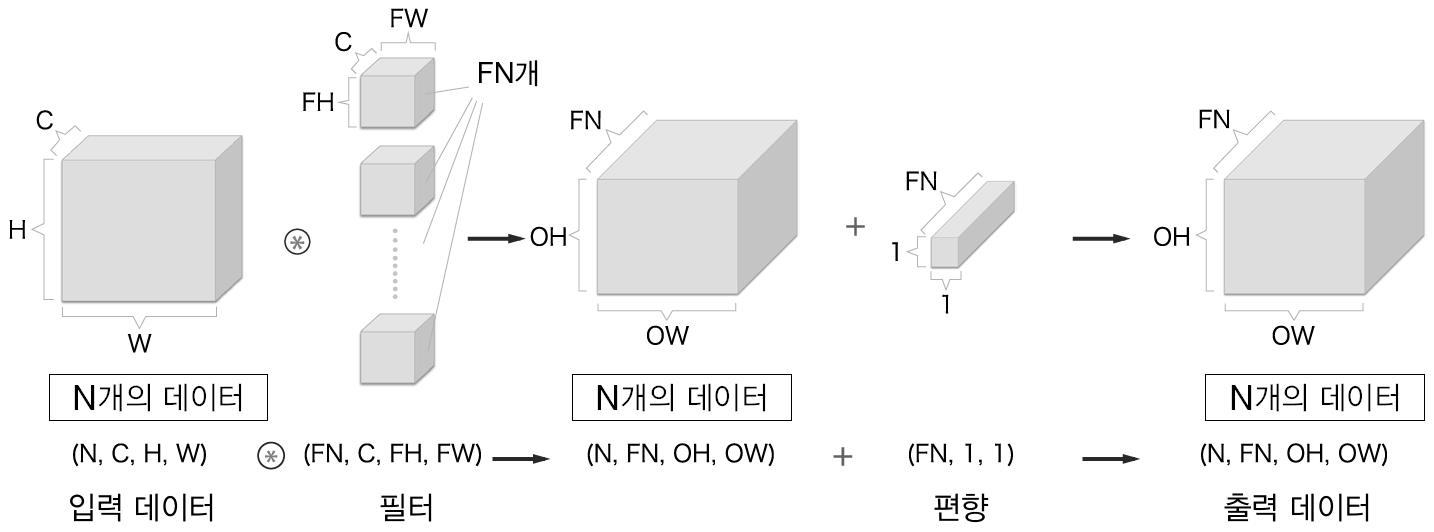

In [25]:
im = Image.open('deep_learning_images/fig 7-13.png')
im

- 차원을 하나 더 늘려 4차원 데이터로 저장(데이터 수, 채널 수, 높이, 너비)
- 4차원 데이터가 하나 흐를 때마다 데이터 N개에 대한 합성곱 연산이 이루어진다.

### 풀링 계층

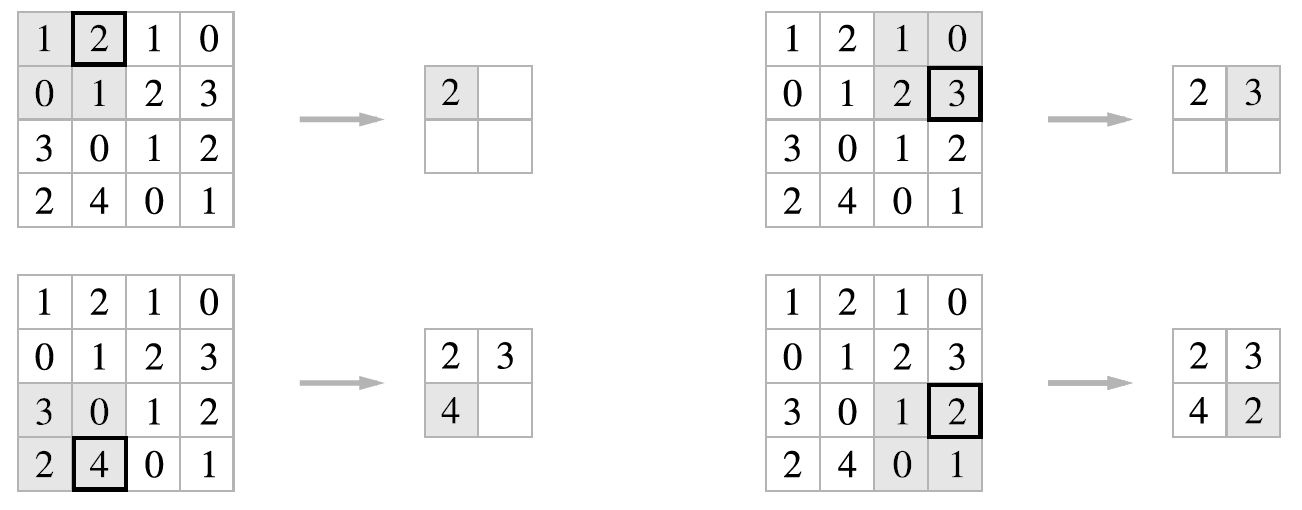

In [27]:
im = Image.open('deep_learning_images/fig 7-14.png')
im

- 최대 풀링과 평균 풀링이 있다.
- 풀링의 크기와 스트라이드는 같은 값으로 설정하는 것이 일반적
- 특징 1. 학습해야 할 매개변수가 없다.
- 특징 2. 채널 수가 변하지 않는다.
- 특징 3. 입력의 변화에 영향을 적게받는다.(로버스트)

### 7. 4 합성곱/풀링 계층 구현하기

- for문 겹겹 비효율 /  넘파이 for문 성능 안좋다
- im2col함수를 쓰자

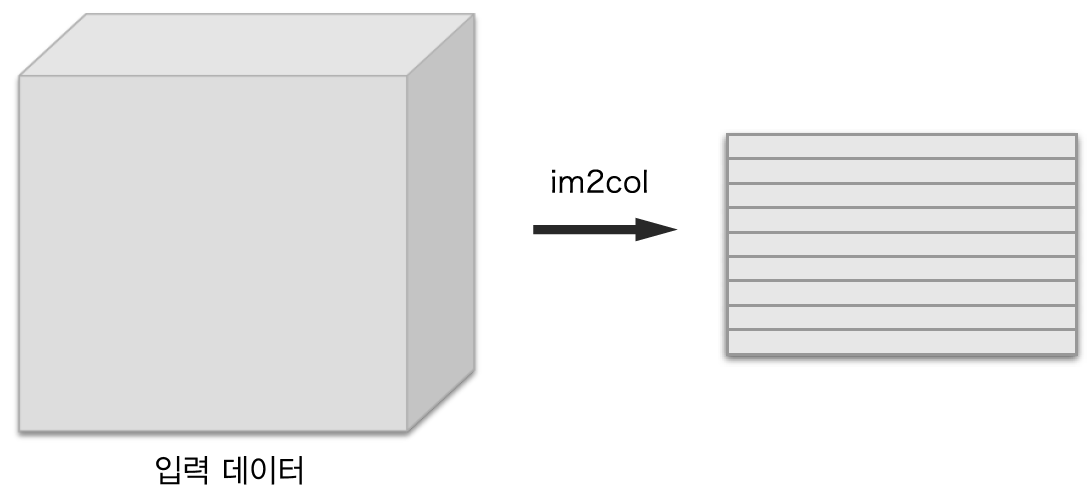

In [30]:
im = Image.open('deep_learning_images/fig 7-17.png')
im

- im2col 은 입력 데이터를 필터링(가중치 계산)하기 좋게 전개하는 (펼치는) 함수
- 3차원 입력데이터가 2차원 행렬로 바뀌었음

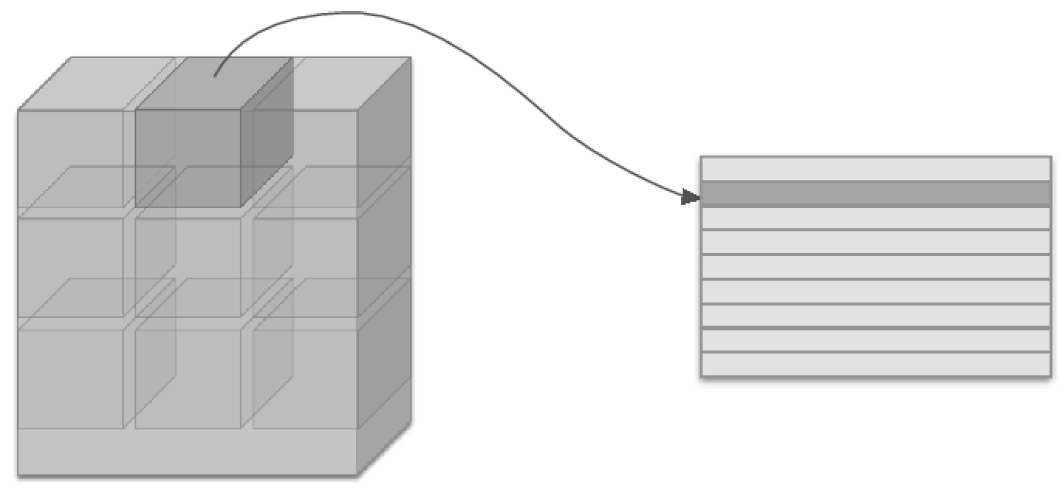

In [32]:
im = Image.open('deep_learning_images/fig 7-18.png')
im

- 실제로는 위 그림처럼 깔끔하게 덩어리 안져
- 필터 적용 영역이 겹치게 되어 전개 후 원소 수가 원래 블록의 원소 수보다 많아진다.
- 따라서 메모리 많이 소비하는 단점이 있다.  하지만 선형대수 라이브러리와 효율이 좋다.

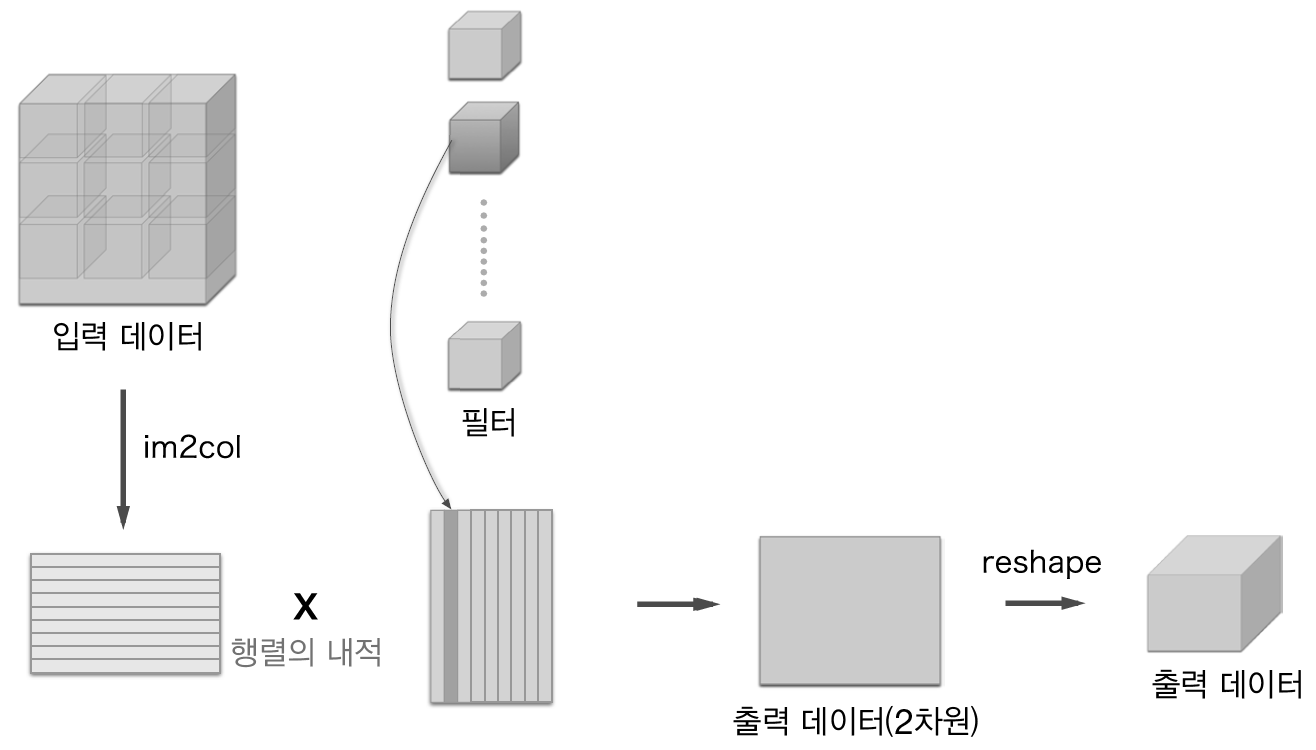

In [34]:
im = Image.open('deep_learning_images/fig 7-19.png')
im

- im2col 로 입력 데이터 전개한다.
- 합성곱 계층의 필터(가중치)를 1열로 전개한다.
- 두 행렬의 내적을 계산한다.
- 마지막으로 출력 데이터를 reshape 한다.

### 구현

In [35]:

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


In [ ]:

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

### 풀링계층 구현

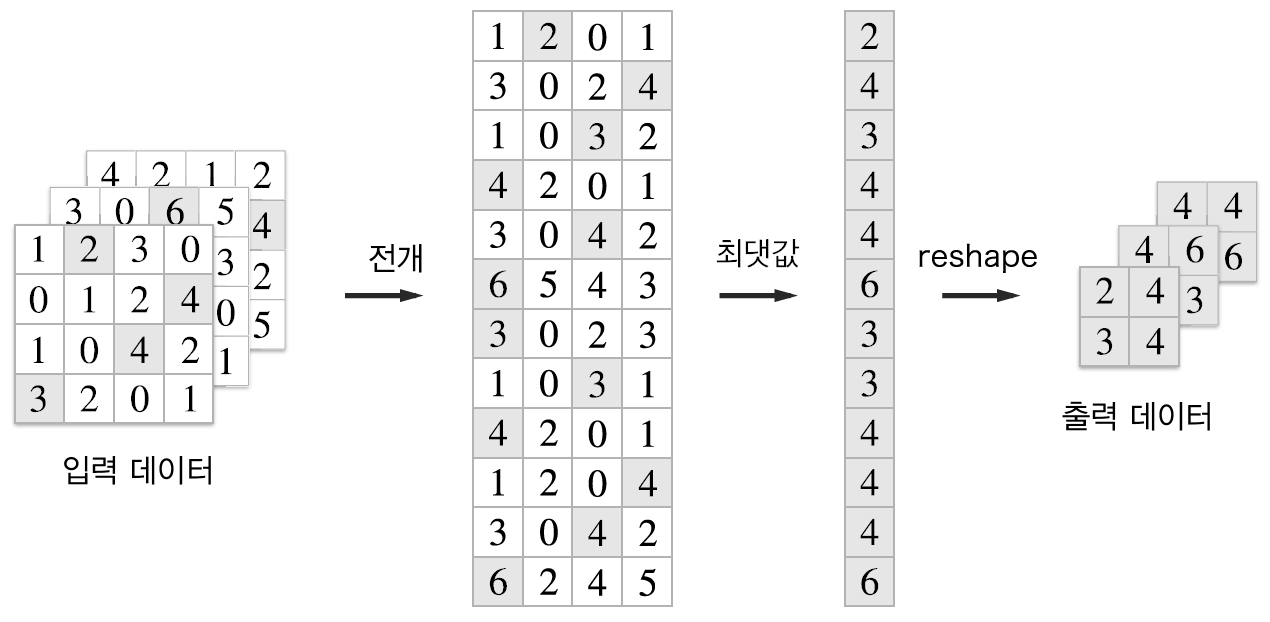

In [37]:
im = Image.open('deep_learning_images/fig 7-22.png')
im

- 학습이 진행된 후 필터는 어느정도 블롭(덩어리) 에지(세로에 반응하나 가로에 반응하나)를  나타나게 됨
- 계층이 깊어 질수록 반응하는 뉴런은 더 추상화된다 -> ex 1층은 에지와 블롭 3층은 텍스쳐 5층은 사물의 일부
- 즉, 층이 깊어지면서 뉴런이 반ㅇ응하는 대상이 단순 모양에서 고급정보로 변화 -> 사물의 의미를 이해하도록 변화한다는것

### 7. 7 대표적인 CNN

### LeNet
- 98년 시그모이드 함수사용 / 서브샘플링을 통해 데이터가 작아지기만하는 등 구림

### AlexNet

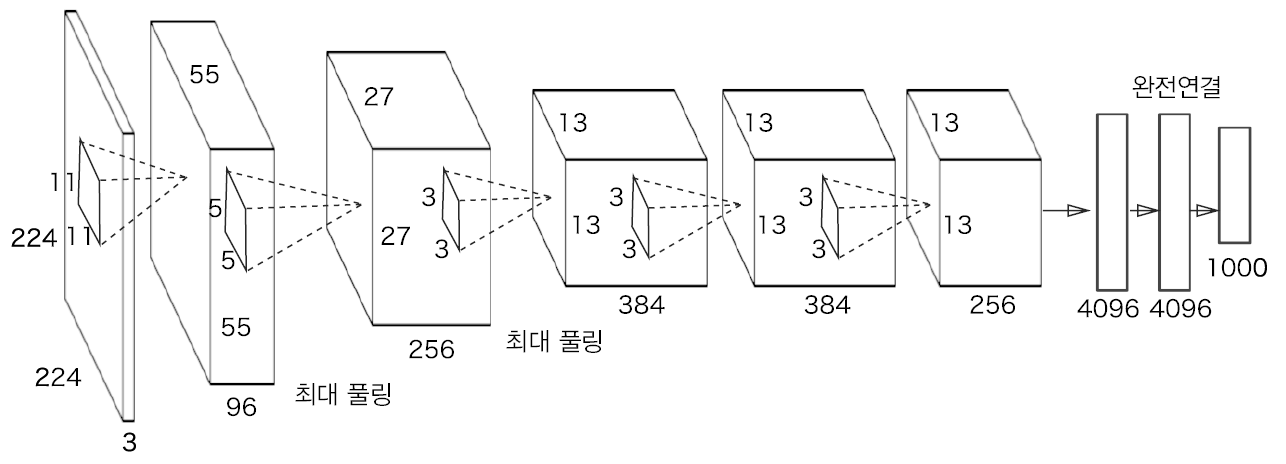

In [42]:
im = Image.open('deep_learning_images/fig 7-28.png')
im

- 활성화 함수로 ReLU를 이용
- LRN이라는 국소적 정규화 실시하는 계층을 이용
- 드롭아웃 사용